#### Modules

In [1]:
# --- Core libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import geopandas as gpd
from shapely.geometry import Point
from tabulate import tabulate

# --- Scikit-learn: model training, preprocessing, CV, evaluation ---
from sklearn.model_selection import (
    GroupKFold,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    balanced_accuracy_score,
    roc_auc_score,
    make_scorer,
    ConfusionMatrixDisplay
)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import BallTree

# --- XGBoost ---
from xgboost import XGBRegressor, plot_tree, plot_importance
import xgboost  # Optional: useful for checking version

# --- Other ---
from haversine import haversine
import scipy.stats as stats
import folium
from shapely.geometry import Point # For geographic data handling (questionable coordinates)



# ---- Temporal and Spatial Autocorrelation ----
from skgstat import Variogram 
from skgstat import SpaceTimeVariogram
from statsmodels.graphics.tsaplots import plot_acf #for temporal autocorrelation


#--- Custom Functions as defined by the user ---
import sys
sys.path.append(os.path.abspath("tools"))
import functions




In [2]:
# for visualising tables: 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Define data summary function 

In [3]:
df_raw = pd.read_csv("../../../data/finaldatasets/testdata/finalfr/finalfrfr/jittered_eng_cleaned.csv")  # for variogram, etc.


In [4]:
functions.summarize_dataframe(df_raw)

| variable                           | dtype   |   count |   pct_complete |   n_unique |
|------------------------------------|---------|---------|----------------|------------|
| id                                 | int64   |   22709 |          100   |      22315 |
| EvapS6                             | float64 |   22709 |          100   |       1075 |
| Trans8                             | float64 |   22709 |          100   |       1070 |
| Trans7                             | float64 |   22709 |          100   |       1056 |
| Trans6                             | float64 |   22709 |          100   |       1047 |
| Trans5                             | float64 |   22709 |          100   |       1008 |
| Trans4                             | float64 |   22709 |          100   |       1015 |
| Trans3                             | float64 |   22709 |          100   |       1067 |
| Trans2                             | float64 |   22709 |          100   |       1075 |
| Trans1             

In [5]:
# See how many unique locations vs total records
unique_locations = df_raw.groupby(["Conversion.for.latitude", "Conversion.for.longitude"]).size()
print(f"Total records: {len(df_raw)}")
print(f"Unique locations: {len(unique_locations)}")
print(f"Average records per location: {len(df_raw) / len(unique_locations):.2f}")

Total records: 22709
Unique locations: 240
Average records per location: 94.62


In [6]:

pd.set_option('display.max_rows',None )  # Limit display for clarity
# Group by location and summarize year range
temporal_range_per_location = df_raw.groupby(
    ["Conversion.for.latitude", "Conversion.for.longitude"]
)["year"].agg(['min', 'max', 'nunique']).reset_index()

# Rename columns for clarity
temporal_range_per_location.columns = [
    "lat", "lon", "year_start", "year_end", "n_years"
]

# Sort to see longest or shortest ranges
temporal_range_per_location.sort_values("n_years", ascending=False).head()


,lat,lon,year_start,year_end,n_years
219,51.809472,-0.373000,2005,2020,15
115,35.448861,-119.163944,2005,2019,12
152,38.524167,-121.743944,2005,2019,12
32,27.507472,-109.896694,2005,2019,11
150,38.062694,-121.572361,2005,2019,11


Create a spatial autocorrelation variogram, code inspiriation from : https://phys-techsciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-zwj-zauq

Analyzing 240 unique locations...

SPATIAL AUTOCORRELATION RESULTS
Threshold (Range): 16.1 km
Sill: 6.87
Nugget: 0.00

Current (100km) vs Calculated (16.1km)
Difference: 83.9 km
Recommendation: Consider 16km
💡 Consider adjustment


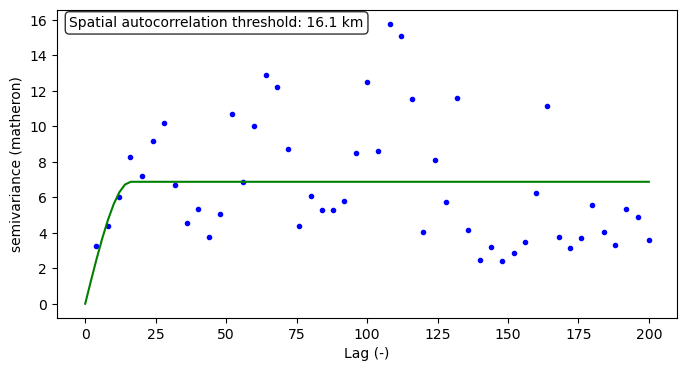

In [ ]:
from skgstat import Variogram
import matplotlib.pyplot as plt

# Step 1: Aggregate yield by unique lat-lon
location_avg = df_raw.groupby(
    ["Conversion.for.latitude", "Conversion.for.longitude"]
)["Grain.yield..tons.ha.1."].mean().reset_index()

# Extract coordinates and values
coordinates = location_avg[["Conversion.for.latitude", "Conversion.for.longitude"]].values
yields = location_avg["Grain.yield..tons.ha.1."].values


def calculate_autocorrelation_threshold(
    coords, values, model='exponential', metric='greatcircle', 
    n_lags=50, max_lag=200
):
    """Fit a semivariogram and return the range (autocorrelation threshold)"""
    variogram = Variogram(
        coordinates=coords,
        values=values,
        model=model,
        metric=metric,
        n_lags=n_lags,
        maxlag=max_lag
    )
    threshold = variogram.parameters[0]
    
    fig = variogram.plot(grid=False, hist=False)
    fig.text(
        0.02, 0.98, f"Spatial autocorrelation threshold: {threshold:.1f} km",
        transform=fig.gca().transAxes, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
    )
    return threshold, fig, variogram


def extract_variogram_params(variogram):
    """Extract sill and nugget from a Variogram object"""
    sill = getattr(variogram, 'sill', None)
    nugget = getattr(variogram, 'nugget', None)
    
    if sill is None and len(variogram.parameters) > 1:
        sill = variogram.parameters[1]
    if nugget is None and len(variogram.parameters) > 2:
        nugget = variogram.parameters[2]
        
    return sill, nugget


def assess_clustering_distance(current_km, threshold_km, tolerance=25):
    """Compare current clustering distance to estimated threshold"""
    diff = abs(current_km - threshold_km)
    recommendation = (
        f"Keep {current_km}km" if diff < tolerance else f"Consider {threshold_km:.0f}km"
    )
    return {
        'difference': diff,
        'within_tolerance': diff < tolerance,
        'recommendation': recommendation
    }


# === FUNCTION CALL (easy to tweak) ===
print(f"Analyzing {len(coordinates)} unique locations...")
sp_threshold, fig, variogram = calculate_autocorrelation_threshold(
    coords=coordinates,
    values=yields,
    model='spherical',           # try 'exponential' or 'gaussian'
    metric='greatcircle',        # haversine distance (in km)
    n_lags=50,
    max_lag=200
)

sill, nugget = extract_variogram_params(variogram)

# === Print summary ===
print("\n" + "="*50)
print("SPATIAL AUTOCORRELATION RESULTS")
print("="*50)
print(f"Threshold (Range): {sp_threshold:.1f} km")
if sill is not None: print(f"Sill: {sill:.2f}")
if nugget is not None: print(f"Nugget: {nugget:.2f}")

# === Evaluate clustering strategy ===
evaluation = assess_clustering_distance(100, sp_threshold)
print(f"\nCurrent (100km) vs Calculated ({sp_threshold:.1f}km)")
print(f"Difference: {evaluation['difference']:.1f} km")
print(f"Recommendation: {evaluation['recommendation']}")
print(" Well-justified!" if evaluation['within_tolerance'] else "💡 Consider adjustment")
